In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [3]:
gta_image=Image.open('data/GTA5/Images/03_images/images/07498.png').convert('RGB')
imgnet1=Image.open('image1.jpg').convert('RGB')
imgnet2=Image.open('image2.jpg').convert('RGB')
gt=Image.open('data/GTA5/GT/03_labels/labels/07498.png')

In [4]:
print(np.array(gta_image).shape)
print(cv2.imread('data/GTA5/Images/03_images/images/07498.png').shape)
# torch.Size([3, 1052, 1914])

(1052, 1914, 3)
(1052, 1914, 3)


In [7]:
def add_salt_and_pepper(image, amount):

    output = np.copy(np.array(image))

    # add salt
    nb_salt = np.ceil(amount * output.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(nb_salt)) for i in output.shape]
    output[coords] = 1

    # add pepper
    nb_pepper = np.ceil(amount* output.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(nb_pepper)) for i in output.shape]
    output[coords] = 0

    return Image.fromarray(output)

In [37]:
import skimage
import matplotlib.pyplot as plt
img_path="data/GTA5/Images/03_images/images/07498.png"
img = skimage.io.imread(img_path)
gimg = skimage.util.random_noise(img, mode='gaussian')
# gimg*255
# plt.imshow(gimg)
# gimg.shape
gimg=Image.fromarray(gimg.astype('uint8'))
type(gimg)


PIL.Image.Image

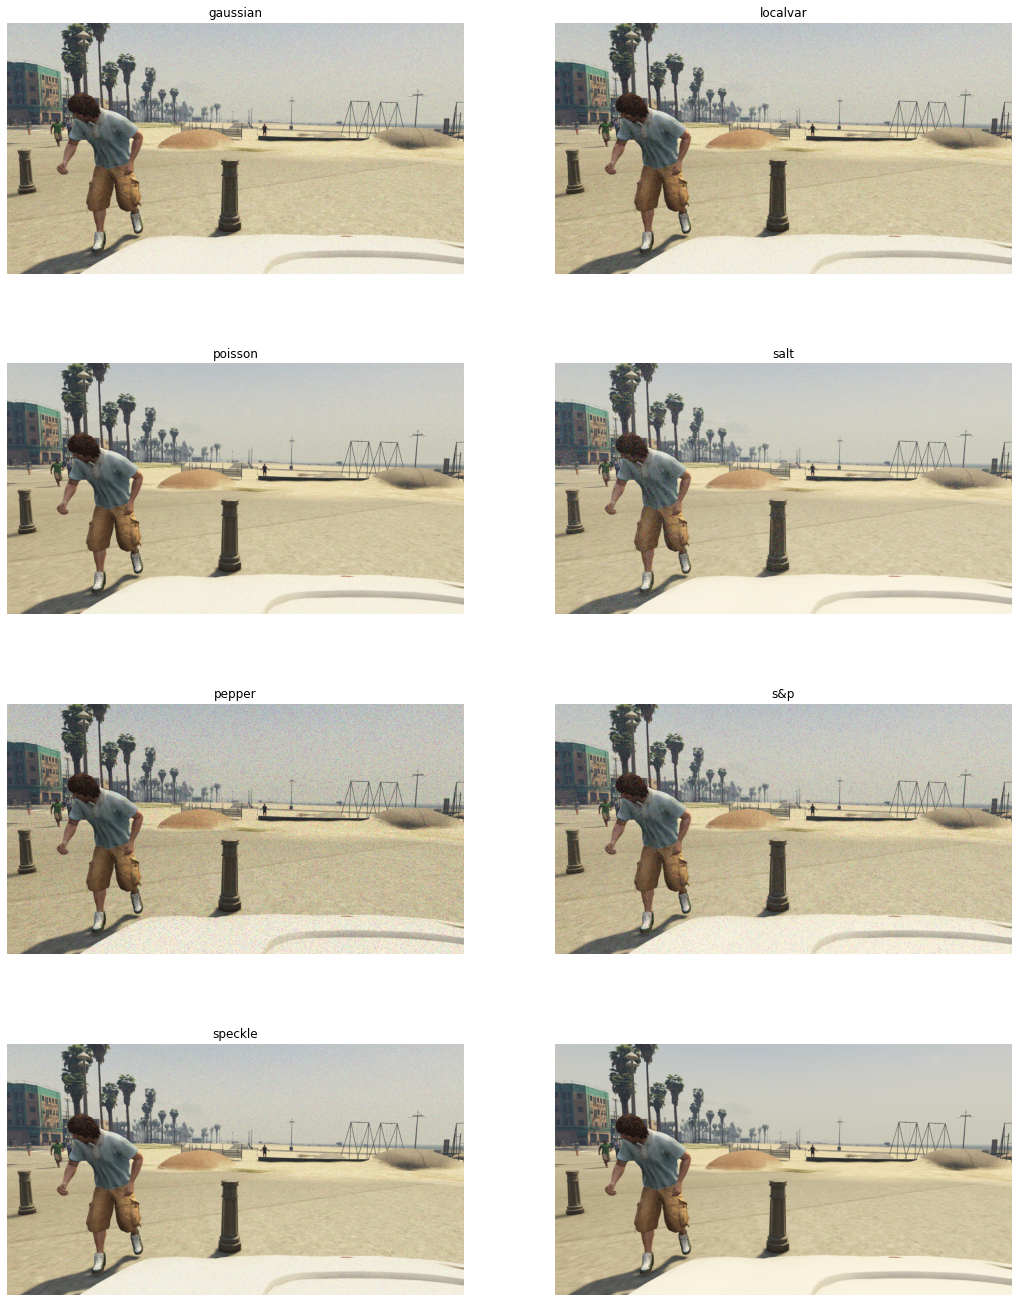

In [27]:
import skimage
import matplotlib.pyplot as plt
img_path="data/GTA5/Images/03_images/images/07498.png"
img = skimage.io.imread(img_path)/255.0

def plotnoise(img, mode, r, c, i):
    plt.subplot(r,c,i)
    if mode is not None:
        gimg = skimage.util.random_noise(img, mode=mode)
        plt.imshow(gimg)
    else:
        plt.imshow(img)
    plt.title(mode)
    plt.axis("off")

plt.figure(figsize=(18,24))
r=4
c=2
plotnoise(img, "gaussian", r,c,1)
# plotnoise(img, "localvar", r,c,2)
# plotnoise(img, "poisson", r,c,3)
# plotnoise(img, "salt", r,c,4)
# plotnoise(img, "pepper", r,c,5)
# plotnoise(img, "s&p", r,c,6)
# plotnoise(img, "speckle", r,c,7)
# plotnoise(img, None, r,c,8)
# plt.show()

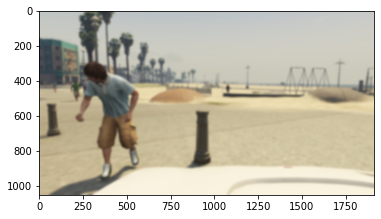

In [25]:
from PIL import Image, ImageFilter 
im2 = gta_image.filter(ImageFilter.GaussianBlur(radius = 5))
plt.imshow(im2)

In [199]:
np.array(gt).shape

(1052, 1914)

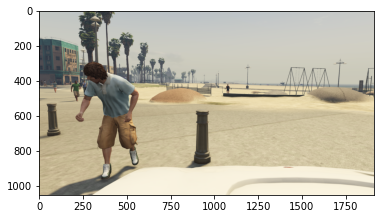

In [200]:
plt.imshow(gta_image)

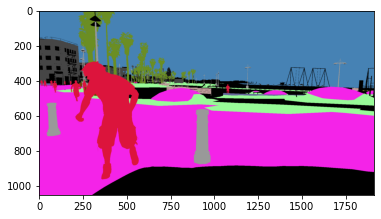

In [201]:
plt.imshow(gt)


In [202]:
gt=np.array(gt)
gt.shape

(1052, 1914)

In [213]:
np.unique(gt)

array([ 0,  1,  4,  5,  7,  8, 11, 12, 13, 17, 21, 22, 23, 24],
      dtype=uint8)

In [317]:
# # mask_stuff_class=[0,1,7,8,11,12,13,17,19,20,21,22,23]
# mask_stuff_class=[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,29,30] # ignore 고려
# mask_things_class=[24,25,26,27,28,31,32,33]

# st_th=[]
# for i in np.unique(gt):
#     if i in mask_stuff_class+mask_things_class:
#         st_th.append(i)
# print(st_th)

[0, 1, 4, 5, 7, 8, 11, 12, 13, 17, 21, 22, 23, 24]


In [220]:
# mask_stuff_class=[0,1,7,8,11,12,13,17,19,20,21,22,23]
mask_stuff_class=[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,29,30] # ignore 고려
mask_things_class=[24,25,26,27,28,31,32,33]

st=[]
th=[]
for i in np.unique(gt):
    if i in mask_stuff_class:
        st.append(i)
for i in np.unique(gt):
    if i in mask_things_class:
        th.append(i)
print(st)
print(th)  

[0, 1, 4, 5, 7, 8, 11, 12, 13, 17, 21, 22, 23]
[24]


In [233]:
tot=st+th
tot

[0, 1, 4, 5, 7, 8, 11, 12, 13, 17, 21, 22, 23, 24]

In [223]:
## class별로 각각 다 뽑기
# masked_stuff=[ gt[:,:] ==i for i in mask_stuff_class ]
masked_stuff=[ gt[:,:] ==i for i in st ]
masked_things=[ gt[:,:] ==i for i in th ]


In [318]:
print(np.shape(masked_stuff))
print(np.shape(masked_things))
print(len(st)+len(th)) ## unique class 14개 -> 14개 imagenet 뽑아야함
unique_class=len(st)+len(th)
# unique_class=len(tot)

(13, 1052, 1914)
(1, 1052, 1914)
14


In [256]:
def color_transfer(source, target, clip=True, preserve_paper=True):
    """
    Transfers the color distribution from the source to the target
    image using the mean and standard deviations of the L*a*b*
    color space.

    This implementation is (loosely) based on to the "Color Transfer
    between Images" paper by Reinhard et al., 2001.

    Parameters:
    -------
    source: NumPy array
        OpenCV image in BGR color space (the source image)
    target: NumPy array
        OpenCV image in BGR color space (the target image)
    clip: Should components of L*a*b* image be scaled by np.clip before 
        converting back to BGR color space?
        If False then components will be min-max scaled appropriately.
        Clipping will keep target image brightness truer to the input.
        Scaling will adjust image brightness to avoid washed out portions
        in the resulting color transfer that can be caused by clipping.
    preserve_paper: Should color transfer strictly follow methodology
        layed out in original paper? The method does not always produce
        aesthetically pleasing results.
        If False then L*a*b* components will scaled using the reciprocal of
        the scaling factor proposed in the paper.  This method seems to produce
        more consistently aesthetically pleasing results 

    Returns:
    -------
    transfer: NumPy array
        OpenCV image (w, h, 3) NumPy array (uint8)
    """
    # convert the images from the RGB to L*ab* color space, being
    # sure to utilizing the floating point data type (note: OpenCV
    # expects floats to be 32-bit, so use that instead of 64-bit)
    source = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype("float32")
    target = cv2.cvtColor(target, cv2.COLOR_BGR2LAB).astype("float32")

    # compute color statistics for the source and target images
    (lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc) = image_stats(source)
    (lMeanTar, lStdTar, aMeanTar, aStdTar, bMeanTar, bStdTar) = image_stats(target)

    # subtract the means from the target image
    (l, a, b) = cv2.split(target)
    l -= lMeanTar
    a -= aMeanTar
    b -= bMeanTar

    if preserve_paper:
        # scale by the standard deviations using paper proposed factor
        l = (lStdTar / lStdSrc) * l
        a = (aStdTar / aStdSrc) * a
        b = (bStdTar / bStdSrc) * b
    else:
        # scale by the standard deviations using reciprocal of paper proposed factor
        l = (lStdSrc / lStdTar) * l
        a = (aStdSrc / aStdTar) * a
        b = (bStdSrc / bStdTar) * b

    # add in the source mean
    l += lMeanSrc
    a += aMeanSrc
    b += bMeanSrc

    # clip/scale the pixel intensities to [0, 255] if they fall
    # outside this range
    l = _scale_array(l, clip=clip)
    a = _scale_array(a, clip=clip)
    b = _scale_array(b, clip=clip)

    # merge the channels together and convert back to the RGB color
    # space, being sure to utilize the 8-bit unsigned integer data
    # type
    transfer = cv2.merge([l, a, b])
    transfer = cv2.cvtColor(transfer.astype("uint8"), cv2.COLOR_LAB2BGR)
    
    # return the color transferred image
    return transfer

def image_stats(image):
    """
    Parameters:
    -------
    image: NumPy array
        OpenCV image in L*a*b* color space

    Returns:
    -------
    Tuple of mean and standard deviations for the L*, a*, and b*
    channels, respectively
    """
    # compute the mean and standard deviation of each channel
    (l, a, b) = cv2.split(image)
    (lMean, lStd) = (l.mean(), l.std())
    (aMean, aStd) = (a.mean(), a.std())
    (bMean, bStd) = (b.mean(), b.std())

    # return the color statistics
    return (lMean, lStd, aMean, aStd, bMean, bStd)

def _min_max_scale(arr, new_range=(0, 255)):
    """
    Perform min-max scaling to a NumPy array

    Parameters:
    -------
    arr: NumPy array to be scaled to [new_min, new_max] range
    new_range: tuple of form (min, max) specifying range of
        transformed array

    Returns:
    -------
    NumPy array that has been scaled to be in
    [new_range[0], new_range[1]] range
    """
    # get array's current min and max
    mn = arr.min()
    mx = arr.max()

    # check if scaling needs to be done to be in new_range
    if mn < new_range[0] or mx > new_range[1]:
        # perform min-max scaling
        scaled = (new_range[1] - new_range[0]) * (arr - mn) / (mx - mn) + new_range[0]
    else:
        # return array if already in range
        scaled = arr

    return scaled

def _scale_array(arr, clip=True):
    """
    Trim NumPy array values to be in [0, 255] range with option of
    clipping or scaling.

    Parameters:
    -------
    arr: array to be trimmed to [0, 255] range
    clip: should array be scaled by np.clip? if False then input
        array will be min-max scaled to range
        [max([arr.min(), 0]), min([arr.max(), 255])]

    Returns:
    -------
    NumPy array that has been scaled to be in [0, 255] range
    """
    if clip:
        scaled = np.clip(arr, 0, 255)
    else:
        scale_range = (max([arr.min(), 0]), min([arr.max(), 255]))
        scaled = _min_max_scale(arr, new_range=scale_range)

    return scaled


In [274]:
transfered=np.zeros([gt.shape[0],gt.shape[1],3])
transfered.shape

(1052, 1914, 3)

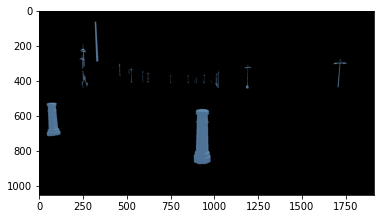

In [312]:
# plt.imshow(np.array(mask_by_class[9]).transpose(1,2,0).astype('uint8'))

['data/imagenet-mini/train/n02037110/n02037110_736.JPEG', 'data/imagenet-mini/train/n02317335/n02317335_55450.JPEG', 'data/imagenet-mini/train/n04328186/n04328186_24514.JPEG', 'data/imagenet-mini/train/n04597913/n04597913_5884.JPEG', 'data/imagenet-mini/train/n04336792/n04336792_3246.JPEG', 'data/imagenet-mini/train/n04613696/n04613696_4993.JPEG', 'data/imagenet-mini/train/n02672831/n02672831_27627.JPEG', 'data/imagenet-mini/train/n03379051/n03379051_5848.JPEG', 'data/imagenet-mini/train/n02100735/n02100735_145.JPEG', 'data/imagenet-mini/train/n04019541/n04019541_41013.JPEG', 'data/imagenet-mini/train/n02791270/n02791270_8740.JPEG', 'data/imagenet-mini/train/n04336792/n04336792_7938.JPEG', 'data/imagenet-mini/train/n03649909/n03649909_21416.JPEG', 'data/imagenet-mini/train/n01592084/n01592084_6358.JPEG']
[[[255. 249. 255.]
  [255. 249. 255.]
  [255. 249. 255.]
  ...
  [255. 249. 255.]
  [255. 249. 255.]
  [255. 249. 255.]]

 [[255. 249. 255.]
  [255. 249. 255.]
  [255. 249. 255.]
  ...

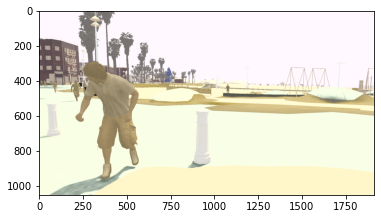

In [315]:
import os
import cv2
import time
item_imgnet=np.random.randint(0,34745,size=unique_class)
image_list_filepath_imgnet=os.path.join('./data_list/imagenet-mini', 'train' + "_imgs.txt")
images_imgnet=[id.strip() for id in open(image_list_filepath_imgnet)]

imgnet_path=[]
for i in range(len(item_imgnet)):
    imgnet_path.append(images_imgnet[item_imgnet[i]])
print(imgnet_path)
mask_by_class=[]
for i in range(len(item_imgnet)):
    # mask=np.zeros(np.shape(gt))

    mask=np.array(gt==tot[i])
    mask=torch.Tensor(mask).unsqueeze(0)
    mask=torch.cat([mask,mask,mask],dim=0)
    mask_gta=mask*(np.array(gta_image).transpose(2,0,1))
    # plt.imshow(np.array(mask_gta).transpose(1,2,0).astype('uint8'))
    imgnet=Image.open(imgnet_path[i]).convert('RGB')
    output=color_transfer(cv2.cvtColor(np.array(imgnet),cv2.COLOR_RGB2BGR),cv2.cvtColor(np.array(mask_gta).transpose(1,2,0).astype('uint8'),cv2.COLOR_RGB2BGR))
    # mask_gta=mask*(np.array(output).transpose(2,0,1))
    mask_by_class.append(mask*(np.array(output).transpose(2,0,1)))



transfered=np.zeros([gt.shape[0],gt.shape[1],3])

for i in range(len(item_imgnet)):
    # print(mask_by_class[i].shape)
    transfered+=np.array(mask_by_class[i]).transpose(1,2,0).astype('uint8')
# print(transfered.shape)

plt.imshow(cv2.cvtColor(transfered.astype('uint8'),cv2.COLOR_BGR2RGB))
print(transfered)
# print(np.array(mask_by_class).shape)

############################## 아래부터 통합

In [122]:
# 통합
mask_stuff=np.zeros(np.shape(gt))
mask_things=np.zeros(np.shape(gt))


In [123]:
for i in mask_stuff_class:
    mask_stuff+=np.array(gt==i)
for i in mask_things_class:
    mask_things+=np.array(gt==i)
    


In [124]:
mask_stuff=torch.Tensor(mask_stuff).unsqueeze(0)
mask_stuff=torch.cat([mask_stuff,mask_stuff,mask_stuff],dim=0)
mask_things=torch.Tensor(mask_things).unsqueeze(0)
mask_things=torch.cat([mask_things,mask_things,mask_things],dim=0)

In [125]:
masked_stuff_gta=mask_stuff*(np.array(gta_image).transpose(2,0,1))
masked_things_gta=mask_things*(np.array(gta_image).transpose(2,0,1))


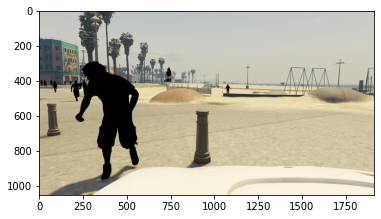

In [126]:
plt.imshow(np.array(masked_stuff_gta).transpose(1,2,0).astype('uint8'))
########################################################################

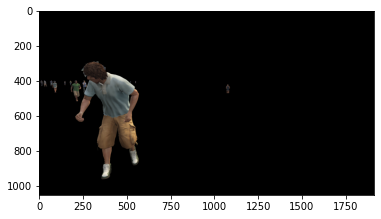

In [127]:
plt.imshow(np.array(masked_things_gta).transpose(1,2,0).astype('uint8'))
########################################################################

In [128]:
np.array(masked_things_gta).transpose(1,2,0).shape

(1052, 1914, 3)

In [129]:
np.array(imgnet1).shape

(333, 500, 3)

In [255]:
def color_transfer(source, target, clip=True, preserve_paper=True):
    """
    Transfers the color distribution from the source to the target
    image using the mean and standard deviations of the L*a*b*
    color space.

    This implementation is (loosely) based on to the "Color Transfer
    between Images" paper by Reinhard et al., 2001.

    Parameters:
    -------
    source: NumPy array
        OpenCV image in BGR color space (the source image)
    target: NumPy array
        OpenCV image in BGR color space (the target image)
    clip: Should components of L*a*b* image be scaled by np.clip before 
        converting back to BGR color space?
        If False then components will be min-max scaled appropriately.
        Clipping will keep target image brightness truer to the input.
        Scaling will adjust image brightness to avoid washed out portions
        in the resulting color transfer that can be caused by clipping.
    preserve_paper: Should color transfer strictly follow methodology
        layed out in original paper? The method does not always produce
        aesthetically pleasing results.
        If False then L*a*b* components will scaled using the reciprocal of
        the scaling factor proposed in the paper.  This method seems to produce
        more consistently aesthetically pleasing results 

    Returns:
    -------
    transfer: NumPy array
        OpenCV image (w, h, 3) NumPy array (uint8)
    """
    # convert the images from the RGB to L*ab* color space, being
    # sure to utilizing the floating point data type (note: OpenCV
    # expects floats to be 32-bit, so use that instead of 64-bit)
    source = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype("float32")
    target = cv2.cvtColor(target, cv2.COLOR_BGR2LAB).astype("float32")

    # compute color statistics for the source and target images
    (lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc) = image_stats(source)
    (lMeanTar, lStdTar, aMeanTar, aStdTar, bMeanTar, bStdTar) = image_stats(target)

    # subtract the means from the target image
    (l, a, b) = cv2.split(target)
    l -= lMeanTar
    a -= aMeanTar
    b -= bMeanTar

    if preserve_paper:
        # scale by the standard deviations using paper proposed factor
        l = (lStdTar / lStdSrc) * l
        a = (aStdTar / aStdSrc) * a
        b = (bStdTar / bStdSrc) * b
    else:
        # scale by the standard deviations using reciprocal of paper proposed factor
        l = (lStdSrc / lStdTar) * l
        a = (aStdSrc / aStdTar) * a
        b = (bStdSrc / bStdTar) * b

    # add in the source mean
    l += lMeanSrc
    a += aMeanSrc
    b += bMeanSrc

    # clip/scale the pixel intensities to [0, 255] if they fall
    # outside this range
    l = _scale_array(l, clip=clip)
    a = _scale_array(a, clip=clip)
    b = _scale_array(b, clip=clip)

    # merge the channels together and convert back to the RGB color
    # space, being sure to utilize the 8-bit unsigned integer data
    # type
    transfer = cv2.merge([l, a, b])
    transfer = cv2.cvtColor(transfer.astype("uint8"), cv2.COLOR_LAB2BGR)
    
    # return the color transferred image
    return transfer

def image_stats(image):
    """
    Parameters:
    -------
    image: NumPy array
        OpenCV image in L*a*b* color space

    Returns:
    -------
    Tuple of mean and standard deviations for the L*, a*, and b*
    channels, respectively
    """
    # compute the mean and standard deviation of each channel
    (l, a, b) = cv2.split(image)
    (lMean, lStd) = (l.mean(), l.std())
    (aMean, aStd) = (a.mean(), a.std())
    (bMean, bStd) = (b.mean(), b.std())

    # return the color statistics
    return (lMean, lStd, aMean, aStd, bMean, bStd)

def _min_max_scale(arr, new_range=(0, 255)):
    """
    Perform min-max scaling to a NumPy array

    Parameters:
    -------
    arr: NumPy array to be scaled to [new_min, new_max] range
    new_range: tuple of form (min, max) specifying range of
        transformed array

    Returns:
    -------
    NumPy array that has been scaled to be in
    [new_range[0], new_range[1]] range
    """
    # get array's current min and max
    mn = arr.min()
    mx = arr.max()

    # check if scaling needs to be done to be in new_range
    if mn < new_range[0] or mx > new_range[1]:
        # perform min-max scaling
        scaled = (new_range[1] - new_range[0]) * (arr - mn) / (mx - mn) + new_range[0]
    else:
        # return array if already in range
        scaled = arr

    return scaled

def _scale_array(arr, clip=True):
    """
    Trim NumPy array values to be in [0, 255] range with option of
    clipping or scaling.

    Parameters:
    -------
    arr: array to be trimmed to [0, 255] range
    clip: should array be scaled by np.clip? if False then input
        array will be min-max scaled to range
        [max([arr.min(), 0]), min([arr.max(), 255])]

    Returns:
    -------
    NumPy array that has been scaled to be in [0, 255] range
    """
    if clip:
        scaled = np.clip(arr, 0, 255)
    else:
        scale_range = (max([arr.min(), 0]), min([arr.max(), 255]))
        scaled = _min_max_scale(arr, new_range=scale_range)

    return scaled


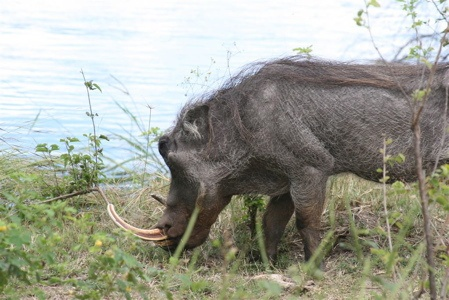

In [131]:
imgnet2

In [132]:
output_things=color_transfer(cv2.cvtColor(np.array(imgnet2),cv2.COLOR_RGB2BGR),cv2.cvtColor(np.array(np.array(masked_things_gta).transpose(1,2,0).astype('uint8')),cv2.COLOR_RGB2BGR))

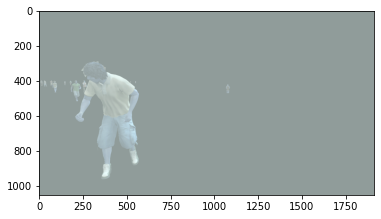

In [133]:
plt.imshow(output_things)

In [134]:
output_things.shape

(1052, 1914, 3)

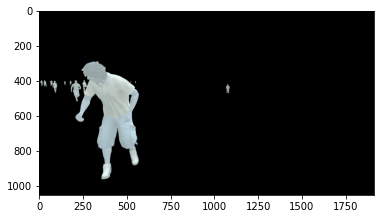

In [135]:
# mask_things=np.zeros(np.shape(gt))
# for i in mask_things_class:
#     mask_things+=np.array(gt==i)
# mask_things=torch.Tensor(mask_things).unsqueeze(0)
# mask_things=torch.cat([mask_things,mask_things,mask_things],dim=0)

# mask 된 이미지의 바탕 제거
masked_things_gta=mask_things*(np.array(output_things).transpose(2,0,1))
plt.imshow(np.array(masked_things_gta).transpose(1,2,0).astype('uint8'))


In [136]:
output_stuff=color_transfer(cv2.cvtColor(np.array(imgnet1),cv2.COLOR_RGB2BGR),cv2.cvtColor(np.array(masked_stuff_gta).transpose(1,2,0).astype('uint8'),cv2.COLOR_RGB2BGR))


In [137]:
output_stuff.shape

(1052, 1914, 3)

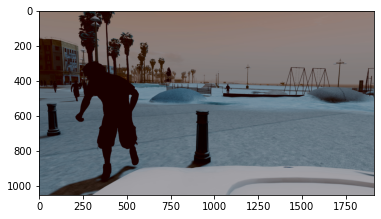

In [138]:
plt.imshow(output_stuff)


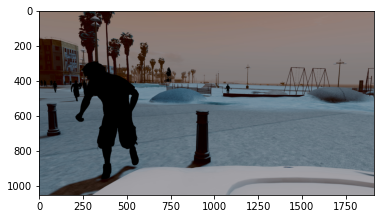

In [139]:

masked_stuff_gta=mask_stuff*(np.array(output_stuff).transpose(2,0,1))
plt.imshow(np.array(masked_stuff_gta).transpose(1,2,0).astype('uint8'))

In [140]:
masked_stuff_gta.min()

tensor(0.)

In [141]:
transfered=np.array(masked_stuff_gta).transpose(1,2,0).astype('uint8')+np.array(masked_things_gta).transpose(1,2,0).astype('uint8')

In [142]:
transfered.shape

(1052, 1914, 3)

In [143]:
### 
# transfered.transpose(2,0,1)

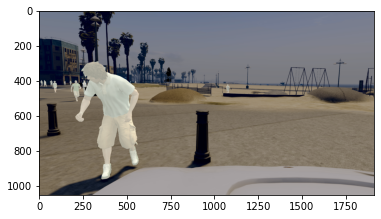

In [147]:
plt.imshow(cv2.cvtColor(transfered,cv2.COLOR_BGR2RGB))

In [484]:
import os
num_lines = sum(1 for line in open('/home/cvintern2/Desktop/intern/OWDA/data_list/imagenet-mini/train_imgs.txt'))
num_lines

34745

In [497]:
test= [id.strip() for id in open('/home/cvintern2/Desktop/intern/OWDA/data_list/imagenet-mini/train_imgs.txt')]
test[num_lines-1]

'data/imagenet-mini/train/n04069434/n04069434_9412.JPEG'

In [492]:
import numpy as np
rand=np.random.randint(0,2,size=2)
rand

array([1, 0])

In [195]:

import tqdm
count = 0
with open('/home/cvintern2/Desktop/intern/OWDA/data_list/GTA5/train_labels.txt', 'r') as fd, open('/home/cvintern2/Desktop/intern/OWDA/data_list/GTA5/train_imgs.txt', 'r') as img:
    reader = fd.readlines()[::-1]
    im=img.readlines()[::-1]
    for i,img in tqdm.tqdm(zip(reader,im)):
        kk=cv2.imread(i.replace("\n", ""),cv2.IMREAD_GRAYSCALE).shape
        # a = np.array(kk).shape
        # print(a)
        kkk=cv2.imread(img.replace("\n", "")).shape
        # aa = np.array(kkk).shape
        if [kk[0],kk[1]] != [kkk[0],kkk[1]]:
            count+=1
            print(count)
            print(i)
            print(img)
            print([kk[0],kk[1]],[kkk[0],kkk[1]])
            # print(i)
            # print(img)
            # print('hi')
print(count)

3869it [04:15, 14.49it/s]

1
data/GTA5/GT/09_labels/labels/20848.png

data/GTA5/Images/09_images/images/20848.png

[697, 1276] [1046, 1914]
2
data/GTA5/GT/09_labels/labels/20827.png

data/GTA5/Images/09_images/images/20827.png

[697, 1276] [1046, 1914]
3
data/GTA5/GT/09_labels/labels/20806.png

data/GTA5/Images/09_images/images/20806.png

[697, 1276] [1046, 1914]


4117it [04:32, 14.49it/s]

4
data/GTA5/GT/09_labels/labels/20860.png

data/GTA5/Images/09_images/images/20860.png

[697, 1276] [1046, 1914]
5
data/GTA5/GT/09_labels/labels/20859.png

data/GTA5/Images/09_images/images/20859.png

[697, 1276] [1046, 1914]
6
data/GTA5/GT/09_labels/labels/20858.png

data/GTA5/Images/09_images/images/20858.png

[697, 1276] [1046, 1914]


4121it [04:32, 14.68it/s]

7
data/GTA5/GT/09_labels/labels/20857.png

data/GTA5/Images/09_images/images/20857.png

[697, 1276] [1046, 1914]
8
data/GTA5/GT/09_labels/labels/20856.png

data/GTA5/Images/09_images/images/20856.png

[697, 1276] [1046, 1914]
9
data/GTA5/GT/09_labels/labels/20855.png

data/GTA5/Images/09_images/images/20855.png

[697, 1276] [1046, 1914]
10
data/GTA5/GT/09_labels/labels/20854.png

data/GTA5/Images/09_images/images/20854.png

[697, 1276] [1046, 1914]


4125it [04:32, 15.19it/s]

11
data/GTA5/GT/09_labels/labels/20853.png

data/GTA5/Images/09_images/images/20853.png

[697, 1276] [1046, 1914]
12
data/GTA5/GT/09_labels/labels/20852.png

data/GTA5/Images/09_images/images/20852.png

[697, 1276] [1046, 1914]
13
data/GTA5/GT/09_labels/labels/20851.png

data/GTA5/Images/09_images/images/20851.png

[697, 1276] [1046, 1914]
14
data/GTA5/GT/09_labels/labels/20850.png

data/GTA5/Images/09_images/images/20850.png

[697, 1276] [1046, 1914]


4129it [04:33, 15.56it/s]

15
data/GTA5/GT/09_labels/labels/20849.png

data/GTA5/Images/09_images/images/20849.png

[697, 1276] [1046, 1914]
16
data/GTA5/GT/09_labels/labels/20847.png

data/GTA5/Images/09_images/images/20847.png

[697, 1276] [1046, 1914]
17
data/GTA5/GT/09_labels/labels/20846.png

data/GTA5/Images/09_images/images/20846.png

[697, 1276] [1046, 1914]
18
data/GTA5/GT/09_labels/labels/20845.png

data/GTA5/Images/09_images/images/20845.png

[697, 1276] [1046, 1914]


4131it [04:33, 15.14it/s]

19
data/GTA5/GT/09_labels/labels/20844.png

data/GTA5/Images/09_images/images/20844.png

[697, 1276] [1046, 1914]
20
data/GTA5/GT/09_labels/labels/20843.png

data/GTA5/Images/09_images/images/20843.png

[697, 1276] [1046, 1914]
21
data/GTA5/GT/09_labels/labels/20842.png

data/GTA5/Images/09_images/images/20842.png

[697, 1276] [1046, 1914]


4135it [04:33, 14.72it/s]

22
data/GTA5/GT/09_labels/labels/20841.png

data/GTA5/Images/09_images/images/20841.png

[697, 1276] [1046, 1914]
23
data/GTA5/GT/09_labels/labels/20840.png

data/GTA5/Images/09_images/images/20840.png

[697, 1276] [1046, 1914]
24
data/GTA5/GT/09_labels/labels/20839.png

data/GTA5/Images/09_images/images/20839.png

[697, 1276] [1046, 1914]


4137it [04:33, 14.14it/s]

25
data/GTA5/GT/09_labels/labels/20838.png

data/GTA5/Images/09_images/images/20838.png

[697, 1276] [1046, 1914]
26
data/GTA5/GT/09_labels/labels/20837.png

data/GTA5/Images/09_images/images/20837.png

[697, 1276] [1046, 1914]
27
data/GTA5/GT/09_labels/labels/20836.png

data/GTA5/Images/09_images/images/20836.png

[697, 1276] [1046, 1914]


4141it [04:33, 14.46it/s]

28
data/GTA5/GT/09_labels/labels/20835.png

data/GTA5/Images/09_images/images/20835.png

[697, 1276] [1046, 1914]
29
data/GTA5/GT/09_labels/labels/20834.png

data/GTA5/Images/09_images/images/20834.png

[697, 1276] [1046, 1914]
30
data/GTA5/GT/09_labels/labels/20833.png

data/GTA5/Images/09_images/images/20833.png

[697, 1276] [1046, 1914]
31
data/GTA5/GT/09_labels/labels/20832.png

data/GTA5/Images/09_images/images/20832.png

[697, 1276] [1046, 1914]


4145it [04:34, 14.50it/s]

32
data/GTA5/GT/09_labels/labels/20831.png

data/GTA5/Images/09_images/images/20831.png

[697, 1276] [1046, 1914]
33
data/GTA5/GT/09_labels/labels/20830.png

data/GTA5/Images/09_images/images/20830.png

[697, 1276] [1046, 1914]
34
data/GTA5/GT/09_labels/labels/20829.png

data/GTA5/Images/09_images/images/20829.png

[697, 1276] [1046, 1914]


4147it [04:34, 14.31it/s]

35
data/GTA5/GT/09_labels/labels/20828.png

data/GTA5/Images/09_images/images/20828.png

[697, 1276] [1046, 1914]
36
data/GTA5/GT/09_labels/labels/20826.png

data/GTA5/Images/09_images/images/20826.png

[697, 1276] [1046, 1914]
37
data/GTA5/GT/09_labels/labels/20825.png

data/GTA5/Images/09_images/images/20825.png

[697, 1276] [1046, 1914]


4151it [04:34, 14.52it/s]

38
data/GTA5/GT/09_labels/labels/20824.png

data/GTA5/Images/09_images/images/20824.png

[697, 1276] [1046, 1914]
39
data/GTA5/GT/09_labels/labels/20823.png

data/GTA5/Images/09_images/images/20823.png

[697, 1276] [1046, 1914]
40
data/GTA5/GT/09_labels/labels/20822.png

data/GTA5/Images/09_images/images/20822.png

[697, 1276] [1046, 1914]


4153it [04:34, 14.21it/s]

41
data/GTA5/GT/09_labels/labels/20821.png

data/GTA5/Images/09_images/images/20821.png

[697, 1276] [1046, 1914]
42
data/GTA5/GT/09_labels/labels/20820.png

data/GTA5/Images/09_images/images/20820.png

[697, 1276] [1046, 1914]
43
data/GTA5/GT/09_labels/labels/20819.png

data/GTA5/Images/09_images/images/20819.png

[697, 1276] [1046, 1914]


4157it [04:35, 14.32it/s]

44
data/GTA5/GT/09_labels/labels/20818.png

data/GTA5/Images/09_images/images/20818.png

[697, 1276] [1046, 1914]
45
data/GTA5/GT/09_labels/labels/20817.png

data/GTA5/Images/09_images/images/20817.png

[697, 1276] [1046, 1914]
46
data/GTA5/GT/09_labels/labels/20816.png

data/GTA5/Images/09_images/images/20816.png

[697, 1276] [1046, 1914]


4159it [04:35, 14.23it/s]

47
data/GTA5/GT/09_labels/labels/20815.png

data/GTA5/Images/09_images/images/20815.png

[697, 1276] [1046, 1914]
48
data/GTA5/GT/09_labels/labels/20814.png

data/GTA5/Images/09_images/images/20814.png

[697, 1276] [1046, 1914]
49
data/GTA5/GT/09_labels/labels/20813.png

data/GTA5/Images/09_images/images/20813.png

[697, 1276] [1046, 1914]


4163it [04:35, 14.10it/s]

50
data/GTA5/GT/09_labels/labels/20812.png

data/GTA5/Images/09_images/images/20812.png

[697, 1276] [1046, 1914]
51
data/GTA5/GT/09_labels/labels/20811.png

data/GTA5/Images/09_images/images/20811.png

[697, 1276] [1046, 1914]
52
data/GTA5/GT/09_labels/labels/20810.png

data/GTA5/Images/09_images/images/20810.png

[697, 1276] [1046, 1914]


4165it [04:35, 14.15it/s]

53
data/GTA5/GT/09_labels/labels/20809.png

data/GTA5/Images/09_images/images/20809.png

[697, 1276] [1046, 1914]
54
data/GTA5/GT/09_labels/labels/20808.png

data/GTA5/Images/09_images/images/20808.png

[697, 1276] [1046, 1914]
55
data/GTA5/GT/09_labels/labels/20807.png

data/GTA5/Images/09_images/images/20807.png

[697, 1276] [1046, 1914]


4169it [04:35, 14.30it/s]

56
data/GTA5/GT/09_labels/labels/20805.png

data/GTA5/Images/09_images/images/20805.png

[697, 1276] [1046, 1914]
57
data/GTA5/GT/09_labels/labels/20804.png

data/GTA5/Images/09_images/images/20804.png

[697, 1276] [1046, 1914]
58
data/GTA5/GT/09_labels/labels/20803.png

data/GTA5/Images/09_images/images/20803.png

[697, 1276] [1046, 1914]


4171it [04:36, 14.24it/s]

59
data/GTA5/GT/09_labels/labels/20802.png

data/GTA5/Images/09_images/images/20802.png

[697, 1276] [1046, 1914]
60
data/GTA5/GT/09_labels/labels/20801.png

data/GTA5/Images/09_images/images/20801.png

[697, 1276] [1046, 1914]


7256it [08:02, 15.58it/s]

61
data/GTA5/GT/08_labels/labels/17705.png

data/GTA5/Images/08_images/images/17705.png

[1052, 1914] [526, 957]


9773it [10:53, 16.11it/s]

62
data/GTA5/GT/07_labels/labels/15188.png

data/GTA5/Images/07_images/images/15188.png

[1052, 1914] [526, 957]


24966it [28:02, 14.84it/s]

62


In [24]:
import torch.nn as nn
cri=nn.BCELoss()

In [31]:
# y1=torch.cat([torch.ones((2,1,8,16)),torch.zeros((2,1,8,16))])
# y2=torch.cat([torch.zeros((2,1,8,16)),torch.ones((2,1,8,16))])
y1=torch.ones(2,1,8,16)
y2=torch.zeros(2,1,8,16)

t=torch.rand((2,1,8,16))

In [32]:
k1=cri(t,y1)
k2=cri(t,y2)

In [33]:
print(k1)
print(k2)

tensor(0.9984)
tensor(1.0116)


In [34]:
t

tensor([[[[0.4286, 0.9883, 0.5834, 0.2322, 0.3011, 0.5548, 0.5034, 0.1960,
           0.3434, 0.5760, 0.3369, 0.2734, 0.2656, 0.4009, 0.7042, 0.7843],
          [0.6277, 0.2312, 0.8425, 0.5290, 0.6325, 0.9600, 0.2568, 0.6663,
           0.5772, 0.2818, 0.4411, 0.6832, 0.7816, 0.3020, 0.4113, 0.9307],
          [0.9836, 0.6762, 0.1304, 0.6814, 0.0824, 0.7631, 0.9409, 0.2911,
           0.8957, 0.0931, 0.6271, 0.5474, 0.8325, 0.0816, 0.4457, 0.9570],
          [0.2373, 0.1550, 0.1496, 0.7428, 0.2498, 0.6075, 0.0877, 0.4498,
           0.6651, 0.7200, 0.7416, 0.1748, 0.6450, 0.1913, 0.0975, 0.7829],
          [0.4144, 0.9597, 0.0078, 0.6809, 0.9768, 0.4860, 0.3265, 0.5192,
           0.9185, 0.8677, 0.4691, 0.6933, 0.3610, 0.3083, 0.8715, 0.3186],
          [0.8502, 0.4268, 0.6298, 0.9796, 0.3680, 0.6311, 0.3804, 0.9993,
           0.4698, 0.7133, 0.1016, 0.7827, 0.7646, 0.1616, 0.5707, 0.7422],
          [0.8916, 0.5049, 0.0166, 0.2281, 0.5615, 0.2207, 0.6410, 0.1374,
           0.3539, 